# Tesco Data Science Assignment

This code repository solves tasks described at [`assignment/tesco_DS_assignment.pdf`](../assignment/tesco_DS_assignment.pdf).

The instructions to install the virtual environment and the Python kernel to run this notebook are in the [`README.md`](../README.md) file.

To make this notebook more readable, I have created a Python model, which I import here. Due to the short time, I have not developed these functions with reusability in mind. Given more time, I would refactor them so this analysis could be reused in other projects.

Usually, I would make the code in the notebook even shorter, exposing only relevant options and using it more as a communication tool than a coding environment. However, I assume you would appreciate seeing some development here, so I included more code than I would. 

# Summary of main findings

## Q1:

* Potential issues with the dataset were identified. The strong correlation between `normalised_sales` and `county`, along with some bias between the `train` and `test` set, is the most noticeable feature of the dataset.

* Some suggestions were added about the future developments of this dataset. The suggestions included:

    1. translating the `normalised_sales` into a more tangible metric
    2. detail how the `normalised_sales` considers the type of store, maintenance, and transportation costs, if it does. If not, add these features.
    3. to break the competitor density per competitor

## Q2:

A Randon Forest model was trained to predict `normalised_sales` on each location. All features but `county` and `location_id` were used in the model. The model was optimised using a Random Search of hyperparameters. I have compared the model performance with Dummy Regressor and with a vanilla Random Forest model. The model performs much better than the Dummy regressor, but the hyperparameter optimisation hasn't been done, which is unsurprising in such a small dataset. 

Inspecting the results, I note that the model slightly subestimates the `normalised_sales` values, especially for the top sales range. Guidance is given on how to interpret the results.

The sales model can be found at [models/tesco_dataset/tesco_sales_model.pkl](../models/tesco_dataset/tesco_sales_model.pkl).
To load the model, you can run the following commands in Python:

```python
import joblib
sales_model = joblib.load("models/tesco_dataset/tesco_sales_model.pkl")

print("The required input features for this model are:")
print(",\n".join(sales_model.feature_names_in_))
```

## Q3:

Using the model created in Q2, I strongly recommend opening stores in locations 148, 400, and 477 and strongly recommend **not** opening in location 114. A more nuanced view is presented for the other locations. I have also placed them with respect to the other stores in the dataset so non-technical decision-makers can quickly identify how these potential stores would perform in comparison to existing stores. A [presentation](https://docs.google.com/presentation/d/10cf3d1t99Uznn3wze9HzeybepQNHmqOcg1uCfwIz3-U/edit#slide=id.g2b854166a7b_0_14) was created to digest this information.

# Masked dataset

I created a model to predict $y$ in function of $x_1$ and $x_2$. For that, I have trained multiple models and encountered that a Gradient Boosting Regressor coupled with a PCA decomposition was the best-performing model.

I used a Linear Regression model to write $y$ as a function of $x_1$ and $x_2$, which was beneficial to get some insight into the behaviour of the dataset.

I recommend using the Gradient Boosting Regressor as the final predictor, but to keep the linear model in mind in order to better understand the problem.

The masked model can be found at [models/masked_dataset/masked_model_GBR_PCA.pkl](../models/masked_dataset/masked_model_GBR_PCA.pkl).
To load the model, you can run the following commands in Python:

```python
import joblib
masked_model = joblib.load("models/masked_dataset/masked_model_GBR_PCA.pkl")

print("The required input features for this model are:")
print(",\n".join(masked_model.feature_names_in_))
```

---

> **General instructions:** 
> - This task is intended to be a general DS assessment. If you have applied for an Operational Research role, please contact your recruiter. 
> - Please, explain any step or though that you think may be important to evaluate your task. 
> - The expected programming language is **python**
> 
> - For the sake of the review, we **strongly prefer** to receive back a jupyter notebook containing all the code, comments and thoughts. This notebook should work from end to end, so we can `restart and run all` or  go through it, cell by cell, if we needed to do so.

---

In [1]:
# Move to the correct directory
import os
import sys

module_path = os.path.abspath(os.path.join(".."))
os.chdir(module_path)

In [2]:
# Import all necessary code and libraries
from IPython.display import display, Markdown
from scipy.stats import randint
from sklearn.decomposition import PCA
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import RandomizedSearchCV, train_test_split
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap

from tesco.data import preprocessing
from tesco.exploration.inspection import distribution_view, top_correlated_features
from tesco import masked_model
from tesco import sales_model
from tesco.utils import bland_altman_plot

---

> # TESCO STORES Dataset

> At Tesco, the location of a retail store plays a huge role in its commercial success. Our Stores Team use various data sources to better understand the potential of candidate locations for new stores in the UK. They need data science help in designing a model that can predict the future sales **[normalised_sales]** of a store based on location characteristics. Your task is to examine the provided dataset and answer the questions below.
> 
> Dataset files
> * `tesco-dataset/train.csv`
> * `tesco-dataset/test.csv`
> 
> Columns
> * `location_id`: id of Tesco property location
> * `normalised_sales`: normalised sales value of Tesco store
> * `crime_rate`: crime rate in the area (higher means more crime)
> * `household_size`: mean household size in the area
> * `household_affluency`: mean household affluency in the area (higher means more affluent)
> * `public_transport_dist`: index of public transport availability in the area
> * `proportion_newbuilds`: proportion of newly built property in the area
> * `property_value`: average property value in the area
> * `commercial_property`: percentage of commercial properties in the area
> * `school_proximity`: average school proximity in the area
> * `transport_availability`: availability of different transport
> * `new_store`: new Tesco store opened recently
> * `proportion_nonretail`: proportion of non-retail commercial properties in the area
> * `competitor_density`: density of competitor retailers
> * `proportion_flats`: proportion of blocks of flats in the area
> * `county`: county code of the area

-------------

> ## Q1
> Before diving into the modelling, you are given the dataset and the Stores Team expect you to come back with an analysis of the data and any concerns you may have about it. They would also like to know which other information you think would be useful to collect for future developments.

---

In [3]:
# Make minimal adjustments to the dataset
preprocessing.run()

🚀 Starting preprocessing...
	🗃 Loading tesco_dataset data...
	🔨 Preprocessing tesco_dataset data...
	💾 Saving data...
📦 Data saved at data/preprocessed/tesco_dataset/data.csv
	🗃 Loading masked_dataset data...
	💾 Saving data...
📦 Data saved at data/preprocessed/masked_dataset/data.csv
👋 Preprocessing finished for tesco_dataset and masked_dataset


### The test set is very small

The test set contains 13 locations. The total data is composed of 333 locations. The dataset is not big to start with, but the size of the test set corresponds to ~4% of the data. Working with at least 10-15% of the data reserved for the test set is common practice. This is important to allow for statistically significant validation of the model, to have enough diversity of data to make the test reliable and to establish if the model is overfitting. However, [Question 3](#Q3) suggests that we are using the model to predict sales to this split of the data. Therefore, this is not a problem. 

### The test set is biased in relation to some relevant variables.

1. **Biased variables**: On a visual inspection ([Fig. 1](#Figure-1:)), the test set is notably biased in relation to `crime_rate`, `commercial_property` and `household_size`. The reason I have not performed any statistical analysis to evaluate this is that, as I have mentioned before, the test set is very small, so using statistical tests to detect bias here would not be very productive.
2. **`normalised_sales` missing:** There are no `normalised_sales` values for the test set.
If the idea is to use the model to predict the `normalised_sales` values in this dataset, as [Question 3](#Q3) suggests, that would not be a problem. However, the name “test” is normally used to refer to the dataset used to test the quality of the model, which would not be possible in this case. I assume that you have the correct expected values and you will compare them to my predicted values, so I perform other data splits to train and test a proposed model.

### Figure 1:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


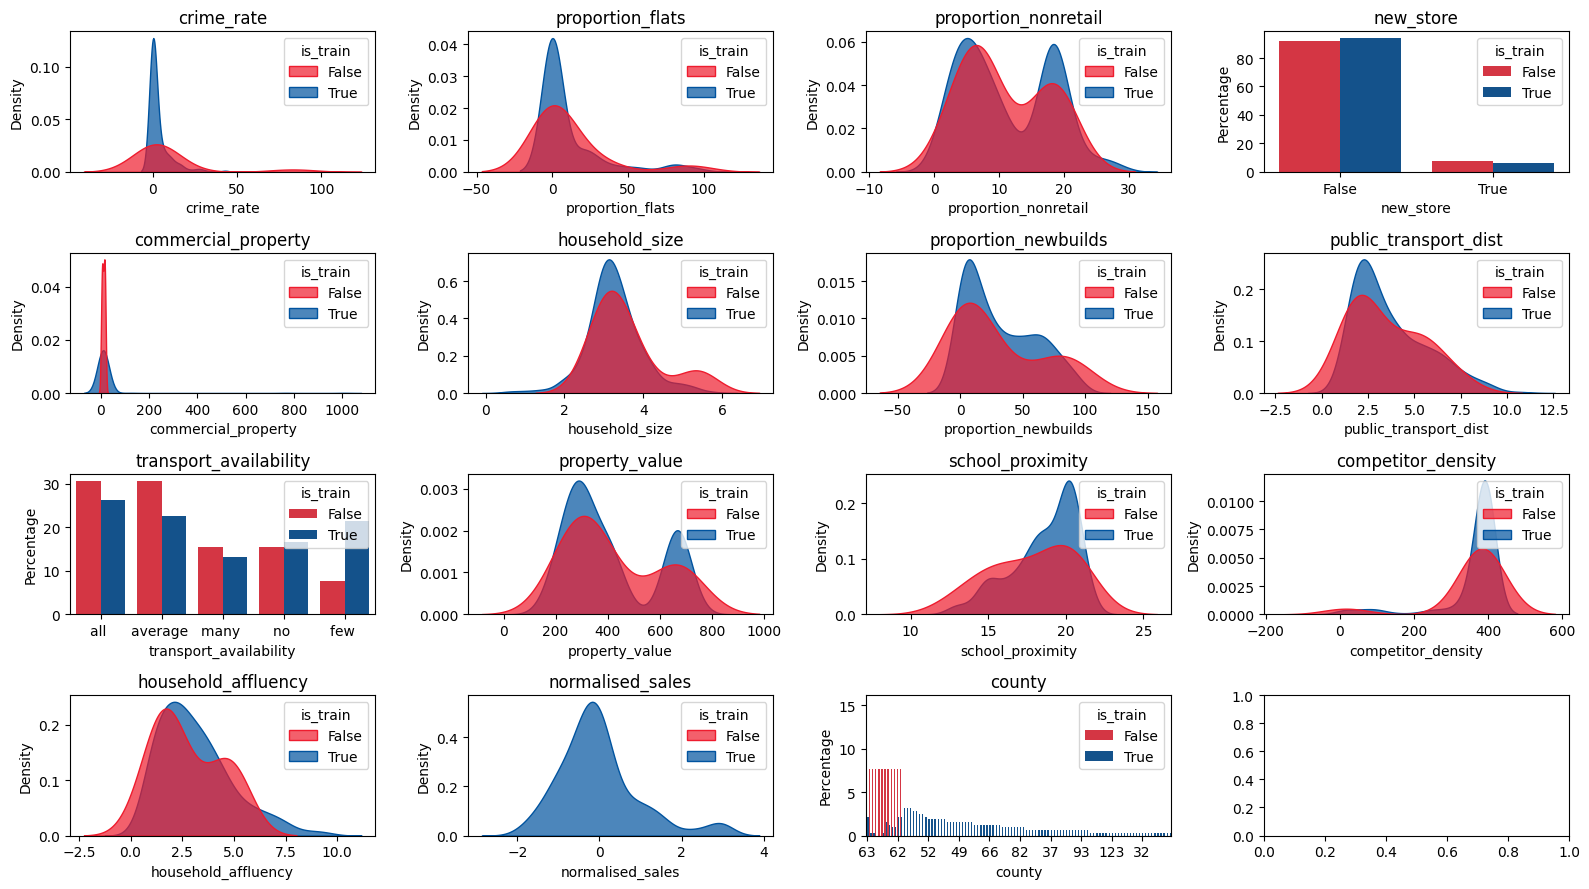

In [4]:
display(Markdown("### Figure 1:"))
df = preprocessing.load_preprocessed_data("tesco_dataset")
fig_1 = distribution_view(df.set_index("location_id"))


### High frequency of zeros in some variables

| Variable | N | % |
| --- | --- | --- |
| `proportion_flats` | 248 | 74.5% |
| `proportion_newbuilds` | 26 | 7.8% |

I would like to confirm with them if these are missing values or actual zero numbers. It is not uncommon in the UK to have regions with only old buildings and no flats, so these could be real values. However, the proportion of regions with no flats seems to be excessive, so I would double-check that.

### The County Code is highly correlated to the target variable

The County code seems to be a linear function with noise from the County Code number, see [Fig. 2](#Figure-2:-Correlation-with-County-Code) and [Table 1](#Table-1:-Correlation-with-County-Code). Other key variables are also correlated to the County code. Notably, household affluence is an exponential function of the code. It looks like the code was designed from a table sorted by `normalised_sales`. Using this variable to train the model would give great results in a validation set (a sub-set of the train data used to measure the model's performance) but would not generalise to unseen counties. We shall exclude this variable from the training set. I would  also ask the Stores Team about how this happened.

I assume that the correlation between the other variables is done by design and is a feature of this (probably synthetic) dataset.
Therefore, I will not raise further questions about their correlations and behaviours.


# Table 1: Correlation with County Code and Normalised Sales

|                       |   Correlation with County Code |
|:----------------------|-------------------------------:|
| county_code           |                      1         |
| normalised_sales      |                      0.793919  |
| household_affluency   |                      0.611673  |
| household_size        |                      0.57991   |
| proportion_nonretail  |                      0.386911  |
| property_value        |                      0.350498  |
| crime_rate            |                      0.316289  |
| proportion_flats      |                      0.313049  |
| proportion_newbuilds  |                      0.312696  |
| school_proximity      |                      0.302263  |
| competitor_density    |                      0.251854  |
| public_transport_dist |                      0.208313  |
| commercial_property   |                      0.0732871 |

|                       |   Correlation with Normalised Sales |
|:----------------------|------------------------------------:|
| normalised_sales      |                           1         |
| county_code           |                           0.793919  |
| household_affluency   |                           0.743277  |
| household_size        |                           0.692506  |
| proportion_nonretail  |                           0.485237  |
| property_value        |                           0.463462  |
| school_proximity      |                           0.447789  |
| crime_rate            |                           0.445005  |
| proportion_newbuilds  |                           0.380474  |
| proportion_flats      |                           0.355756  |
| competitor_density    |                           0.338284  |
| public_transport_dist |                           0.268658  |
| commercial_property   |                           0.0650906 |

# Figure 2: Correlation with County Code and Normalised Sales

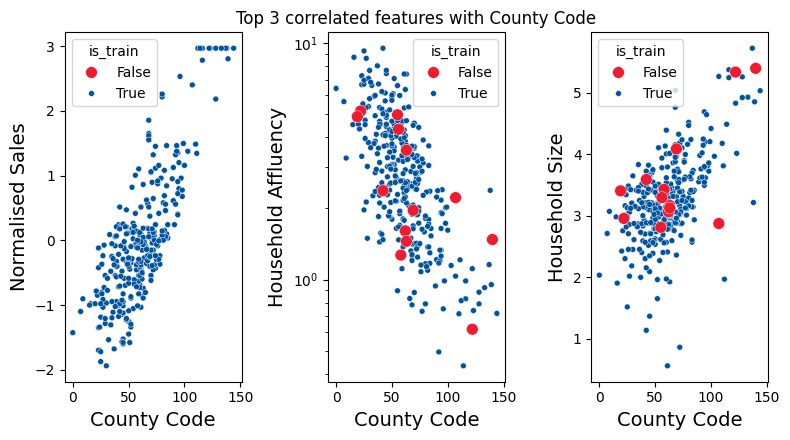

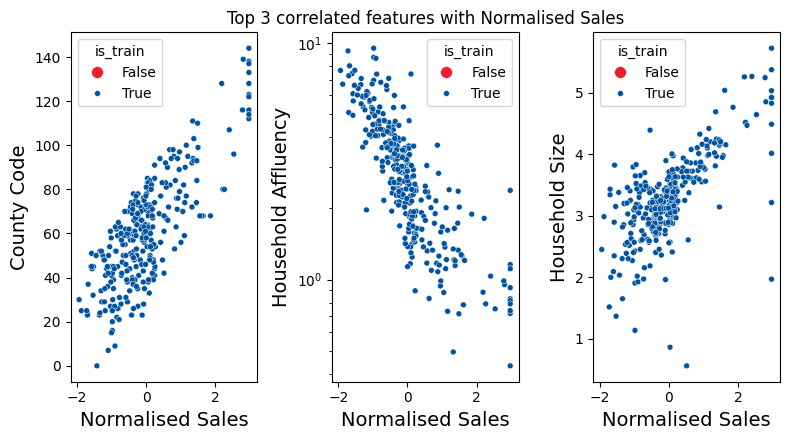

In [5]:
df["county_code"] = df["county"].astype("int")
fig_2a, count_correlated_features = top_correlated_features(df, target="county_code", n_top=3)
fig_2b, sales_correlated_features = top_correlated_features(df, target="normalised_sales", n_top=3)
display(Markdown("# Table 1: Correlation with County Code and Normalised Sales"))
display(Markdown(count_correlated_features.to_markdown()), Markdown(sales_correlated_features.to_markdown()))
display(Markdown("# Figure 2: Correlation with County Code and Normalised Sales"))

> # They would also like to know which other information you think would be useful to collect for future developments.
- Transform the normalised sales into a more tangible metric
    
    It would be interesting to understand how the normalised sales values translate to real £ values. This would help communicate the final results of the model, including predictions of how wrong we can be about a location and how much money that mistake could cost. In the same way, it would help to better understand the threshold on sales that would justify opening a store there.
    
- Type of store, maintenance costs, transportation costs and more
    
    I suppose that the normalization of the sales takes into account the type of store (Extra, Metro, Express, etc.), the maintenance costs and the transportation costs of the stores. The maintenance cost, for instance, may vary substantially depending on the size of the store and features like customer cash/card habits, security, and many others. So, I would like to understand better if these things are considered in the normalisation process or if it would be important to add them as model features. Raising these questions, I would enquire about other characteristics that could be even more important. The Stores Team would likely have people with domain knowledge who could help design this model better.
    
- Competitor density per competitor
    
    I suspect that not all competitors affect sales equally, so breaking down the competitor density by the top brand would be good. I would also investigate how to build a feature like the distance to the closest competitor with a store comparable to or larger than the existing store. A Sainsbury's local next to a Tesco Extra should be less disruptive than the same store next to a Tesco Express, I suppose. However, I would consult the Stores Team on this hypothesis and other hypotheses.

-------------

> ## Q2
> Build a model that can predict store sales based on the provided area features. Please show how you developed the model and report how well your model is performing. ***Constraint:*** Please use Random Forest as the model family to solve this problem.

In [6]:
# Remove the county column and set location_id as the Index
Xy = sales_model.clean_data(df.copy())
# Split the data for Training, validating and testing accordingly
random_state = 1919
# fix random seed for reproducibility
np.random.seed(random_state)
X_train, X_val, X_test, y_train, y_val, y_test = sales_model.split_data(Xy, random_state)
# Create a pipeline to handle preprocessing and model training
# The pipeline applies Standard Scaling of the numerical variables and One Hot Encoding of the categorical variables
numeric_features = X_train.select_dtypes(include=["number"]).columns
categorical_features = X_train.select_dtypes(include=["object", "string"]).columns
# The pipeline is flexible to the use of different models. In this case, I am sticking to the requirement of using Random Forest
model_pipeline = sales_model.create_pipeline(RandomForestRegressor(), numeric_features, categorical_features)

# Use RandomizedSearchCV to optimise the hyperparameters of the model
I have run a much larger search. However, I kept only a small range of parameters here to illustrate the method and minimise the running time of the notebook.
The vanilla model (with the default parameters) was quite good in this instance, so I could not find much improvement. [Table 2](#Table-2:-Model-Performance-Metrics) shows the comparison of the optimised model with the vanilla model. The optimized model shows tyne improvement on the 3 metrics.


In [7]:
param_grid = {
    "Regressor__n_estimators": [80, 100, 120, 200],
    "Regressor__random_state": randint(0, random_state),
}
regressor = RandomizedSearchCV(
    model_pipeline,
    param_distributions=param_grid,
    n_iter=100,
    scoring="neg_mean_squared_error",
    n_jobs=-1,
    cv=5,
    random_state=random_state,
    verbose=1,
)
regressor.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('Preprocessor',
                                              ColumnTransformer(transformers=[('MinMaxScaler '
                                                                               'Numerical '
                                                                               'scaler',
                                                                               MinMaxScaler(),
                                                                               Index(['crime_rate', 'proportion_flats', 'proportion_nonretail',
       'commercial_property', 'household_size', 'proportion_newbuilds',
       'public_transport_dist', 'property_value', 'school_proximity',
       'competitor_densit...
                                                                               Index(['new_store', 'transport_availability'], dtype='object'))])),
                                             ('Regressor',
                                              RandomForestRegressor())]),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'Regressor__n_estimators': [80, 100,
                                                                    120, 200],
                                        'Regressor__random_state': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x71516508f7f0>},
                   random_state=1919, scoring='neg_mean_squared_error',
                   verbose=1)

In [8]:
# Train a baseline model for comparison. I have compared it with a Dummy Regressor, as a Linear Regressor, but here I will use a non-optimised model as a comparison.
baseline_regressor = sales_model.create_pipeline(
    RandomForestRegressor(random_state=random_state), numeric_features, categorical_features
)
baseline_regressor.fit(X_train, y_train)

Pipeline(steps=[('Preprocessor',
                 ColumnTransformer(transformers=[('MinMaxScaler Numerical '
                                                  'scaler',
                                                  MinMaxScaler(),
                                                  Index(['crime_rate', 'proportion_flats', 'proportion_nonretail',
       'commercial_property', 'household_size', 'proportion_newbuilds',
       'public_transport_dist', 'property_value', 'school_proximity',
       'competitor_density', 'household_affluency'],
      dtype='object')),
                                                 ('Categoric encoder',
                                                  OneHotEncoder(handle_unknown='infrequent_if_exist'),
                                                  Index(['new_store', 'transport_availability'], dtype='object'))])),
                ('Regressor', RandomForestRegressor(random_state=1919))])

In [9]:
y_val_pred = regressor.predict(X_val)
y_train_pred = regressor.predict(X_train)
y_test_pred, final_model = sales_model.test_set_prediction(X_train, X_val, X_test, y_train, y_val, regressor)

y_pred_baseline = baseline_regressor.predict(X_val)
y_train_pred_baseline = baseline_regressor.predict(X_train)
y_test_pred_baseline = baseline_regressor.predict(X_test)

df_complete = sales_model.add_predictions_to_df(df, X_train, X_val, X_test, y_train_pred, y_val_pred, y_test_pred)
df_complete_baseline = sales_model.add_predictions_to_df(
    df, X_train, X_val, X_test, y_train_pred_baseline, y_pred_baseline, y_test_pred_baseline
)
model_metrics = sales_model.metrics(df_complete, "normalised_sales", "predicted_normalised_sales")
model_metrics_baseline = sales_model.metrics(
    df_complete_baseline, "normalised_sales", "predicted_normalised_sales", "Vanilla Random Forest Regressor"
)
metrics_comparison = pd.concat([model_metrics, model_metrics_baseline], axis=1)
display(Markdown("# Table 2: Model Performance Metrics"))
display(metrics_comparison)

# Table 2: Model Performance Metrics

,Validation Random Forest,Train Random Forest,Validation Vanilla Random Forest Regressor,Train Vanilla Random Forest Regressor
mean_squared_error,0.262973,0.083498,0.264843,0.095422
mean_absolute_error,0.320012,0.217294,0.329476,0.225402
r2_score,0.795195,0.903440,0.793740,0.889651


# Visual inspection of the results

In this section, I analyse the model's behaviour through two simple visualizations. The first one is a Blant-Altman, and the second one is a simple scatter plot of the predicted variable against the main predictive variables.

### [The Blant-Altman](#Figure-4a:-Visual-inspection-of-predictions")

[The Blant-Altman](#Figure-4a:-Visual-inspection-of-predictions) directly compares the original and predicted data. Using this plot to look at the train and the validation set, we can detect differences in behaviour related to overfitting. Moreover, this provides a look at the stability of the model over the different ranges of the data.

Since using this plot in ML is pretty uncommon, I will give a brief overview of how this can be useful.

For example, if we observe a mean difference far from zero, the model is biased, predicting consistently over or under the expected value.
If the points are twisted in some direction, more mistakes are made for some sections of the target variable space.
The model is overfitting if the training set presents a much smaller dispersion than the validation section.

[Here](#Figure-4a:-Visual-inspection-of-predictions), we see that for large values of `normalised_sales`, the model subestimating the real values. Also, they tend to underestimate the sales in general, resulting in the gap between the green solid line and the dashed red line. These observations will reflect my recommendations on how to use this model.

### [Scatter plots](#Figure-4b:)

The [Scatter plots](#Figure-4b:) here aim to run a quick sanity check of the results. To see if, in general, the predicted results are in line with the natural behaviour of the data. All seems good, except for the extremely high values of `normilised_sales`.



# Figure 4a: Visual inspection of predictions


The palette list has fewer values (2) than needed (3) and will cycle, which may produce an uninterpretable plot.


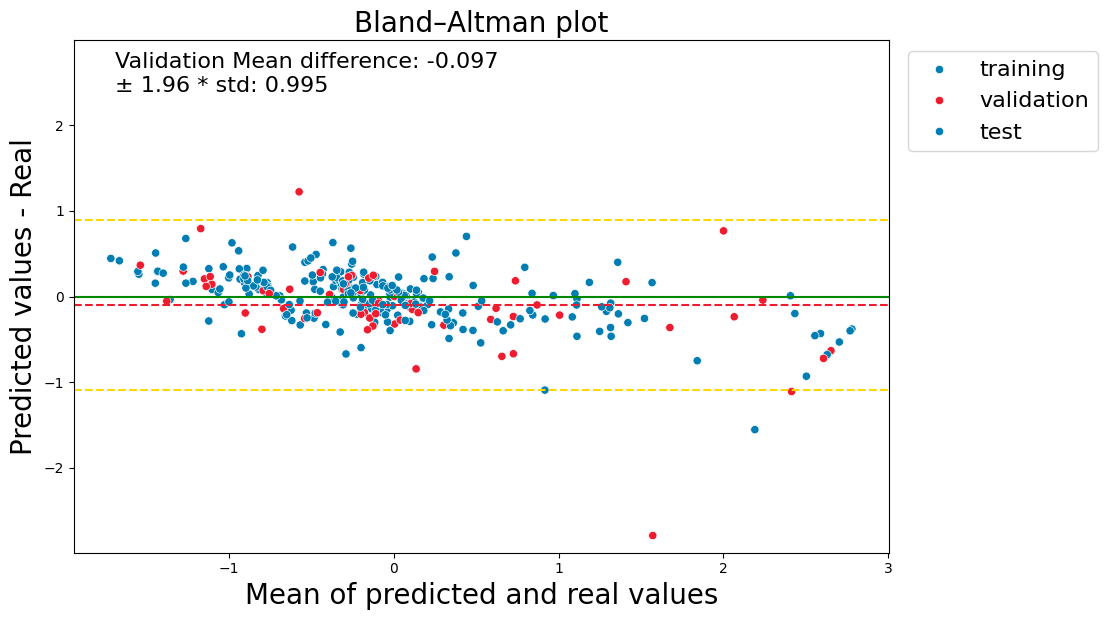

# Figure 4b:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


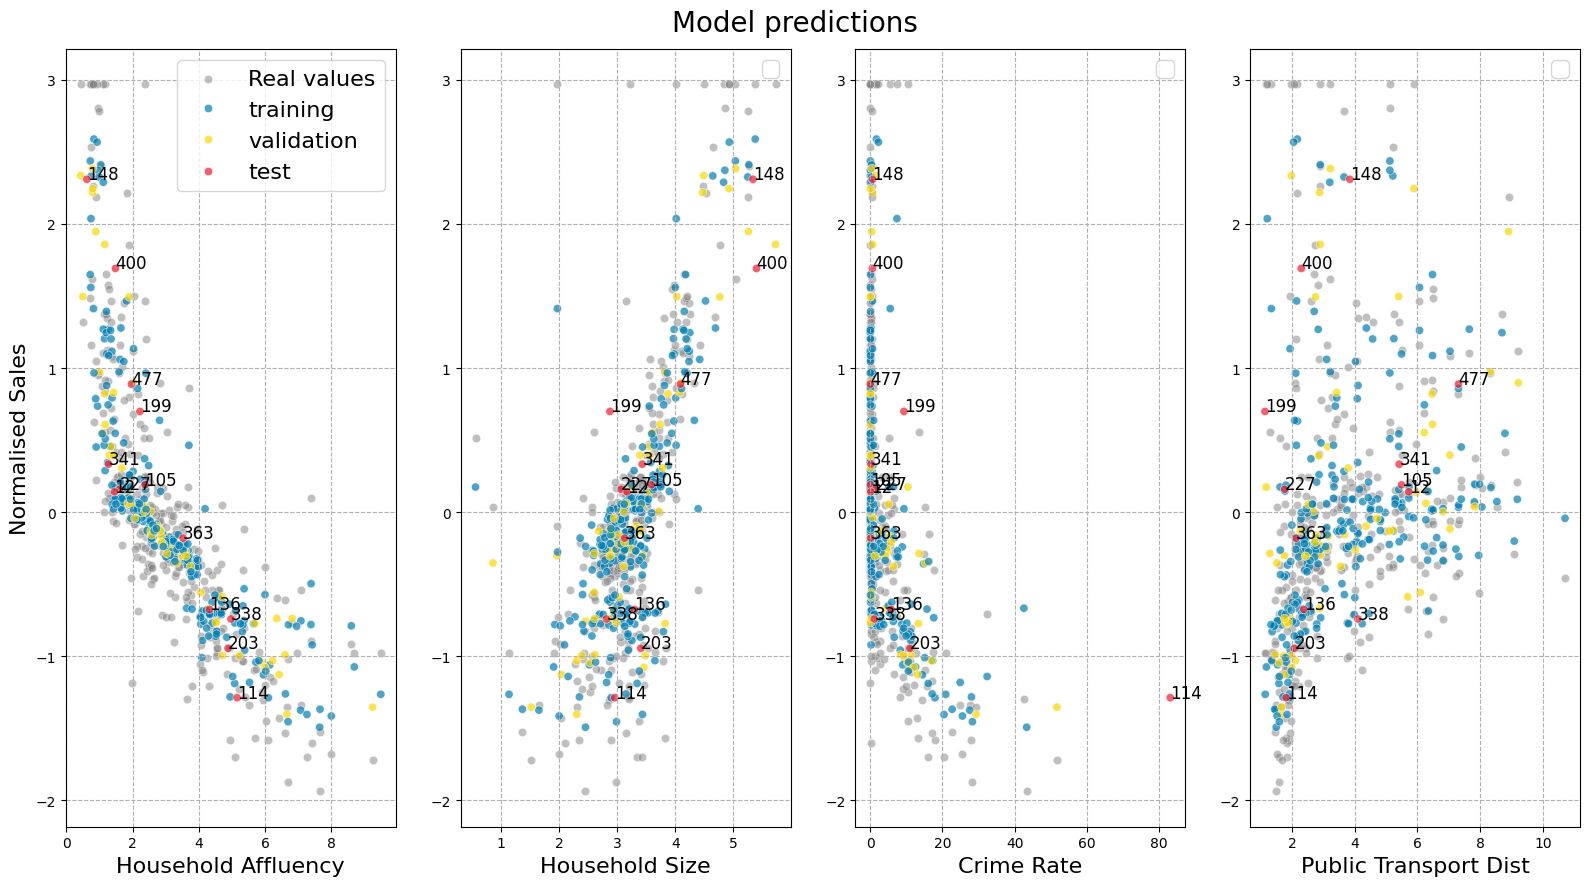

In [10]:
model_path = "models/tesco_dataset/"
os.makedirs(model_path, exist_ok=True)
# %%
display(Markdown("# Figure 4a: Visual inspection of predictions"))
fig = bland_altman_plot(df_complete, target="normalised_sales")
fig.savefig("models/tesco_dataset/tesco_sales_model_bland_altman_plot.png")
plt.show()
display(Markdown("# Figure 4b:"))
fig = sales_model.compare_original_and_predicted_data(df, df_complete)
fig.savefig("models/tesco_dataset/tesco_sales_model_real_data_comparison.png")
plt.show()

# Feature importance

In [Table 1](#Table-1:-Correlation-with-County-Code), I have shared the correlation between the predictive variables and the target variable (`sales_normalised`). This should indicate which features are more important to predict the `normalised_sales` values. However, due to internal correlations between the predictive variables and other model complexities, this information is not 100% reliable.

In this section, I present the Shapley values analysis to measure the contribution of each feature to the model. 

In [Fig. 5](#Figure-5:) we see that the most important features for the model are: `household_affluency`, `household_size`, `crime_rate`, and `public_transport_dist`.


# Figure 5:

PermutationExplainer explainer: 189it [00:17,  5.65it/s]                                                                                                                    


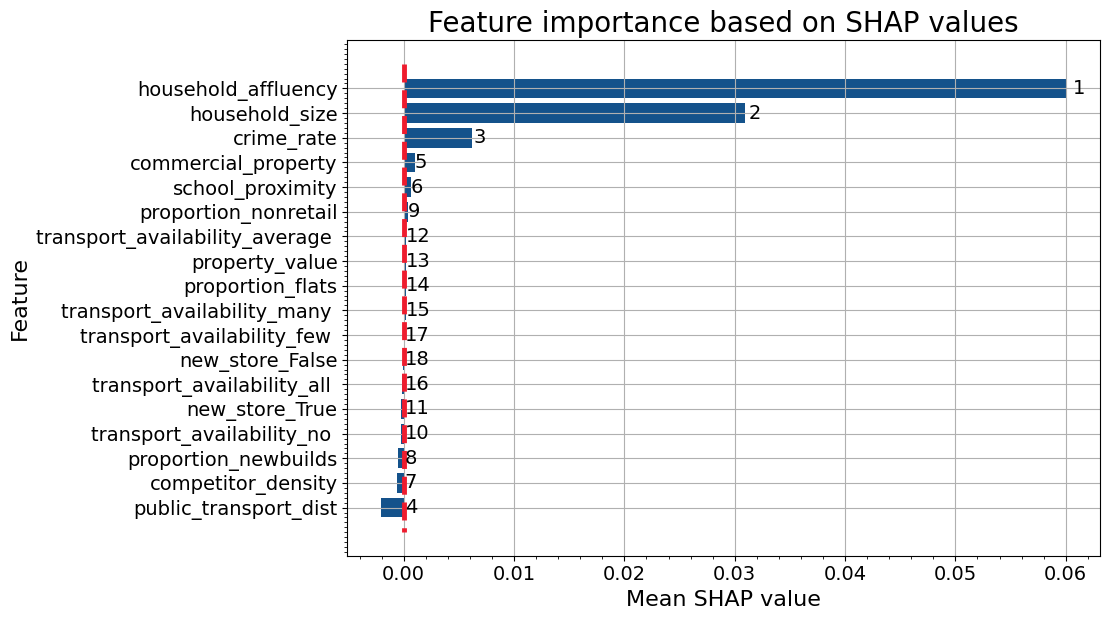

In [11]:
# Feature importance analysisPCA_GradientBoostingRegressor
display(Markdown("# Figure 5:"))
sales_model.feature_importance_analysis(final_model, X_train)
plt.show()

# Model saving

In [12]:
# Save model results
model_file = "tesco_sales_model.pkl"
results_file = "tesco_sales_model_results.csv"
metrics_file = "tesco_sales_model_metrics.csv"
metrics_comparison.to_csv(f"{model_path}{metrics_file}")

test_set = df[~df["is_train"]].copy()
test_set.loc[:, "normalised_sales"] = y_test_pred
sales_quantiles = df["normalised_sales"].quantile([0.25, 0.5, 0.75])
test_set["sales_quartile"] = pd.qcut(
    test_set["normalised_sales"],
    q=100,
    labels=[f"top {100 - percent}%" if percent > 50 else f"bottom {percent}%" for percent in range(0, 100, 1)],
)
test_set.sort_values("normalised_sales", ascending=False, inplace=True)
test_set.to_csv(f"{model_path}{results_file}")
joblib.dump(final_model, f"{model_path}{model_file}")

['models/tesco_dataset/tesco_sales_model.pkl']

-------------

> ## Q3
> The dataset contains a test set of potential store locations. Use your developed model to predict the sales value in these areas and explain what recommendations you would give to the Stores Team to use it. Use any tools that may help you to share your findings with product owners and other non-technical decision makers in the team. Complete this task by explaining how you would improve the current results.

---

### On [this link](https://docs.google.com/presentation/d/10cf3d1t99Uznn3wze9HzeybepQNHmqOcg1uCfwIz3-U/edit#slide=id.g2b854166a7b_0_14) you can find a presentation with the main information here to support communicate with product owners and other non-technical decision makers.

## Summary

### Expected sales:
    
We have created a model to predict the normalised sales values based on location characteristics. This is useful for the Stores Team to decide whether to open new stores in these locations or set performance benchmarks for existing locations. However, it's essential to note that we should avoid using this model for locations included in the training set.
    
### How do you use this model to open new stores?
    
The Stores Team can use the information presented in this report to make informed decisions when opening new stores while considering other business constraints. For instance, if they only have a budget to open three new stores, it would be wise to focus on the locations likely to perform better. In [Table 3](#Table-3:-Predicted-sales), we can observe that stores 148, 400, and 477 rank among the top 20% of the highest normalised sales. Store 148, in particular, is in the top 1%. However, it's important to note that the data on stores top-performing stores is limited, so location 148 may perform at the same level or worse than 400. Therefore, I suggest these two locations are the best options, but if the team can only pick one, they should rely on additional information to decide which of these 2 locations to choose. 
    
Moreover, Stores located in areas 199, 227, and 341, along with the previously mentioned, have the potential to outperform the median Tesco store. With the caveat that location 199 presents an unusually high `crime_rate` and small `household_size` for its value of `household_affluency`. It may mean it's an area in the early stages of gentrification. The model could underperform in such a situation because of the lack of similar data. I would advise the sales team to seek further information on this area.
    
Finally, Assuming that a positive sign on the normalised sales indicates profitability and a negative sign means losses, we would not recommend opening stores in areas 114, 136, 203, 338, and 363 even if there was a budget to open as many stores as possible, especially for location 114, which presents a very high crime rate. The model may not be very accurate in that case, but I would not advise opening a store in those circumstances.

Meanwhile, stores 12 and 105 are expected to be profitable but will likely perform worse than the median Tesco store. 

In [13]:
display(Markdown("# Table 3: Predicted sales"))
top_important_features = ["household_affluency", "household_size", "crime_rate", "public_transport_dist"]
test_set.set_index("location_id")[top_important_features + ["normalised_sales", "sales_quartile"]].sort_values(
    "normalised_sales", ascending=False
)

# Table 3: Predicted sales

,household_affluency,household_size,crime_rate,public_transport_dist,normalised_sales,sales_quartile
location_id,,,,,,
148,0.6175,5.337,0.650078,3.8384,2.309850,top 1%
400,1.4775,5.398,0.587758,2.2885,1.691257,top 9%
477,1.9625,4.088,0.010238,7.3073,0.888654,top 17%
199,2.2200,2.875,9.341992,1.1296,0.699204,top 26%
341,1.2700,3.431,0.216802,5.4159,0.333380,top 34%
105,2.3750,3.590,0.039968,5.4917,0.189712,top 42%
227,1.6075,3.066,1.517409,1.7573,0.159576,bottom 49%
12,1.4525,3.169,0.159895,5.7209,0.141521,bottom 41%
363,3.5225,3.127,0.148222,2.1224,-0.179966,bottom 33%


-------------

> ## Masked Dataset
> 
> You are given the following small dataset, which has been completely masked for privacy reasons. Please train the best model you can come up with to predict the target variable `y` based on the features `x1` and `x2`. Explain every step you take. 
> 
> Assuming that this model will be used for making decisions involving important sums of money, provide any comments that you think you should be giving to the business as a technical expert.
> 
> Dataset files
> * `masked_dataset/train.csv`

# Finding the best model

I have observed that a PCA decomposition of the given dataset returns a straight line with noise, so I have included a PCA decomposition as a potential model optimization technique. The data appears to be already scaled, but I tried scaling it again just to be sure. However, the results remained unaffected, so I did not use any scaling methods in the final model.

I have created a support class to train multiple models at once and compare them effectively. This could also be done using a library like `Pycaret`. However, I have kept it simple to show how such tools can be created from scratch.

In [Table 4](#Table-4:-Masked-Model-Performance), the primary regression metrics for various model approaches are presented. The Gradient Boosting Regressor, coupled with the PCA transformation, has achieved the best results for all three metrics. The model performs quite well, with an $r^2$ of 0.8. As compared to guessing, the model has significantly improved performance; however, the data is quite dispersed. Therefore, I would recommend that users delve into the nature of the random errors and evaluate the model from a business KPIs standpoint before relying on its results.


In [14]:
df = preprocessing.load_preprocessed_data("masked_dataset")
X = df[["x1", "x2"]]
y = df["y"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
models = [
    RandomForestRegressor(random_state=random_state),
    GradientBoostingRegressor(random_state=random_state),
    LinearRegression(),
    Ridge(random_state=random_state),
    DummyRegressor(),
]
decompositions = [PCA(n_components=1, random_state=random_state), None]
scalers = [None]
evaluations = []
selectors = []
for decomposition in decompositions:
    for scaler in scalers:
        model_selector = masked_model.ModelSelector(models, "Regression", decomposition, scaler)
        model_selector.fit(X_train, y_train)
        model_selector.predict(X_test)
        model_selector.evaluate(y_test)
        evaluations.append(model_selector.evaluation_)
        selectors.append(model_selector)
evaluations = pd.concat(evaluations, axis=1).T.sort_values(by="mse")
display(Markdown("# Table 4: Masked Model Performance"))
display(evaluations)

# Table 4: Masked Model Performance

,mse,r2,mae
PCA_GradientBoostingRegressor,0.033545,0.804530,0.152402
PCA_RandomForestRegressor,0.041575,0.757737,0.166877
LinearRegression,0.044158,0.742686,0.173997
Ridge,0.044573,0.740269,0.176081
PCA_LinearRegression,0.046258,0.730450,0.175439
PCA_Ridge,0.046770,0.727468,0.179655
GradientBoostingRegressor,0.047850,0.721170,0.184435
RandomForestRegressor,0.056537,0.670552,0.205477
PCA_DummyRegressor,0.172825,-0.007069,0.342092
DummyRegressor,0.172825,-0.007069,0.342092


# Other helpful information
[Fig. 6](#Figure-6:) shows the Bland-Altman plot for the best model. We see that the model slightly overestimates the values of $y$. The model behaves quite consistently over all values of $y$.

# Figure 6:

['models/masked_dataset/masked_model_GBR_PCA.pkl']

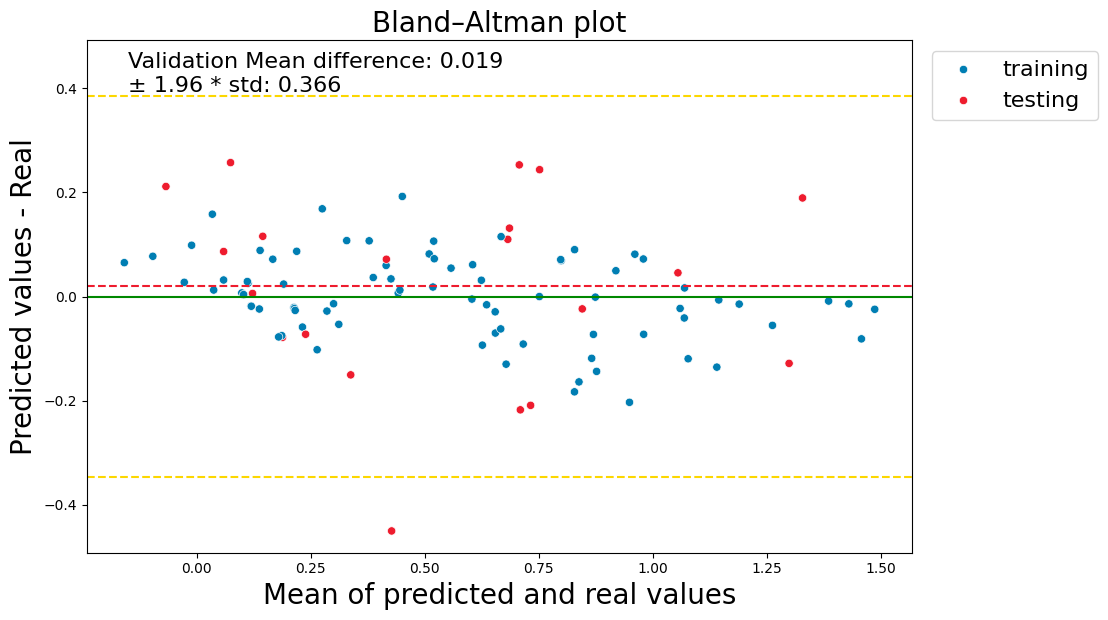

In [15]:
best_model = selectors[0].fitted_models["GradientBoostingRegressor"]
df["dataset"] = "training"
df.loc[X_test.index, "dataset"] = "testing"
best_model.fit(X_train, y_train)
df["predicted_y"] = best_model.predict(df[["x1", "x2"]])
fig = bland_altman_plot(df, target="y", dataset_var="dataset")
display(Markdown("# Figure 6:"))

# Refit model using all the data:
best_model.fit(X, y)
masked_model_path = "models/masked_dataset/"
os.makedirs(masked_model_path, exist_ok=True)
masked_model_file = "masked_model_GBR_PCA.pkl"
joblib.dump(best_model, f"{masked_model_path}{masked_model_file}")

# Model interpretation

To gain a better understanding of the model's behaviour, I decided to investigate the Linear Regression model. By using this model, we can get a clearer view of how the variables are related to each other.

In [Figure 7](#Figure-7:), we display the linear model. The equation below describes the model:

$y(x_1, x_2) = -0.274 + 0.716  x_1 + 1.000  x_2 $

This equation allows us to develop an intuition about the problem. We can observe that doubling the value of $x_2$ results in doubling the value of $y$, but doubling the value of x1 would only increase $y$ by $\approx 70\%$. We can also see that $y$ would be $-0.274$ when $x_1$  and $x_2$ are both 0. This information could be useful depending on the nature of the problem. Additionally, we would have an analytical function that could be integrated over $x_1$  and $x_2$, for example.

However, as we see in [Fig. 8](#Figure-8:-Linear-Regression-Model), the model systematically overestimates the value of $y$ for $y \leq 1.2$ and underestimates $y$ when $y > 0.1$. The Linear model serves as a good intuitive tool, but its performance is not in paired with the Gradient Boost Regressor.


$y(x_1, x_2) = -0.274 + 0.716  x_1 + 1.000  x_2 $


# Figure 7:

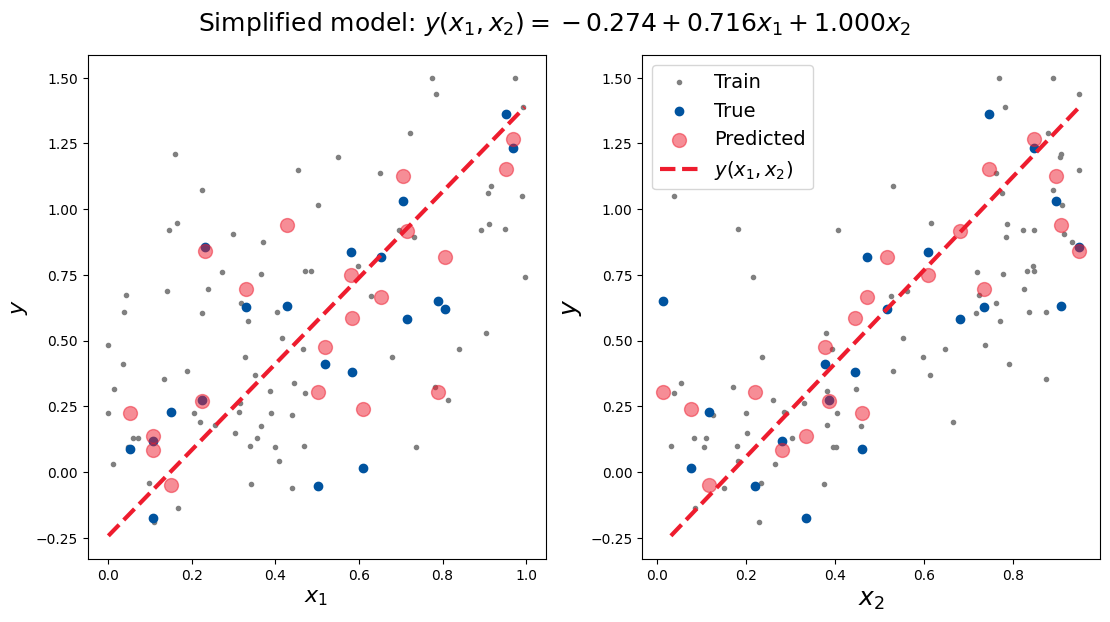

In [16]:
simplest_model = selectors[1]
fig = masked_model.plot_linear_regression_model(simplest_model, X_train, X_test, y_train, y_test)
display(Markdown("# Figure 7:"))

# Figure 8: Linear Regression Model

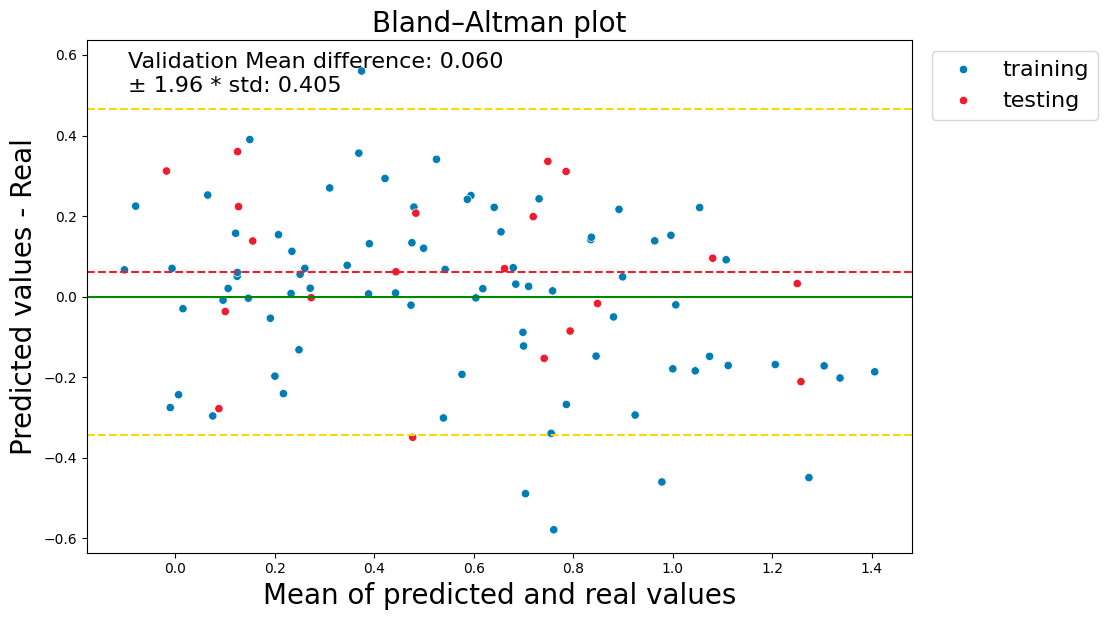

In [17]:
simplest_model = selectors[1].fitted_models["LinearRegression"]
df_lr = df.copy()
best_model.fit(X_train, y_train)
df_lr["predicted_y"] = simplest_model.predict(df[["x1", "x2"]])
fig = bland_altman_plot(df_lr, target="y", dataset_var="dataset")
display(Markdown("# Figure 8: Linear Regression Model"))